In [1]:
from utilities import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import aesara.tensor as at
#from create_training_instance_dictionary_with_covariates import *
#from feature_extraction import *
#from sample_from_full_model import *
from BNN_model import *
# Initialize random number generator
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [23]:
# Settings
true_sigma_obs = 0.5
N_patients = 1000
P = 3 # Number of covariates
P0 = int(P / 2) # A guess of the true number of nonzero parameters is needed for defining the global shrinkage parameter
true_omega = np.array([0.05, 0.10, 0.15])
M_number_of_measurements = 5
days_between_measurements = int(1500/M_number_of_measurements)
measurement_times = days_between_measurements * np.linspace(0, M_number_of_measurements-1, M_number_of_measurements)
treatment_history = np.array([Treatment(start=0, end=measurement_times[-1], id=1)])
true_omega_for_psi = 0.1

# Function to get expected theta from X
def get_expected_theta_from_X_one_interaction(X): # One interaction: In rho_s only
    # These are the true parameters for a patient with all covariates equal to 0:
    N_patients_local, _ = X.shape
    rho_s_population = -0.005
    rho_r_population = 0.001
    pi_r_population = 0.4
    theta_rho_s_population_for_x_equal_to_zero = np.log(-rho_s_population)
    theta_rho_r_population_for_x_equal_to_zero = np.log(rho_r_population)
    theta_pi_r_population_for_x_equal_to_zero  = np.log(pi_r_population/(1-pi_r_population))

    true_alpha = np.array([theta_rho_s_population_for_x_equal_to_zero, theta_rho_r_population_for_x_equal_to_zero, theta_pi_r_population_for_x_equal_to_zero])
    true_beta_rho_s = np.zeros(P)
    true_beta_rho_s[0] = 0.8
    true_beta_rho_s[1] = 0
    interaction_beta_x1_x2_rho_s = -1
    true_beta_rho_r = np.zeros(P)
    true_beta_rho_r[0] = 0.7
    true_beta_rho_r[1] = 1.0
    true_beta_pi_r = np.zeros(P)
    true_beta_pi_r[0] = 0.0
    true_beta_pi_r[1] = 1.1

    expected_theta_1 = np.reshape(true_alpha[0] + np.dot(X, true_beta_rho_s) + np.ravel(interaction_beta_x1_x2_rho_s*X["Covariate 1"]*(X["Covariate 2"].T)), (N_patients_local,1))
    expected_theta_2 = np.reshape(true_alpha[1] + np.dot(X, true_beta_rho_r), (N_patients_local,1))
    expected_theta_3 = np.reshape(true_alpha[2] + np.dot(X, true_beta_pi_r), (N_patients_local,1))
    return expected_theta_1, expected_theta_2, expected_theta_3

def generate_simulated_patients(M_number_of_measurements, days_between_measurements, measurement_times, treatment_history, true_sigma_obs, N_patients_local, P, get_expected_theta_from_X, true_omega, true_omega_for_psi, seed, RANDOM_EFFECTS):
    np.random.seed(seed)
    #X_mean = np.repeat(0,P)
    #X_std = np.repeat(0.5,P)
    #X = np.random.normal(X_mean, X_std, size=(N_patients_local,P))
    X = np.random.uniform(-1, 1, size=(N_patients_local,P))
    X = pd.DataFrame(X, columns = ["Covariate "+str(ii+1) for ii in range(P)])

    expected_theta_1, expected_theta_2, expected_theta_3 = get_expected_theta_from_X(X)

    if RANDOM_EFFECTS:
        true_theta_rho_s = np.random.normal(expected_theta_1, true_omega[0])
        true_theta_rho_r = np.random.normal(expected_theta_2, true_omega[1])
        true_theta_pi_r  = np.random.normal(expected_theta_3, true_omega[2])
    else:
        true_theta_rho_s = expected_theta_1
        true_theta_rho_r = expected_theta_2
        true_theta_pi_r  = expected_theta_3

    psi_population = 50
    true_theta_psi = np.random.normal(np.log(psi_population), true_omega_for_psi, size=N_patients_local)
    true_rho_s = - np.exp(true_theta_rho_s)
    true_rho_r = np.exp(true_theta_rho_r)
    true_pi_r  = 1/(1+np.exp(-true_theta_pi_r))
    true_psi = np.exp(true_theta_psi)

    patient_dictionary = {}
    for training_instance_id in range(N_patients_local):
        psi_patient_i   = true_psi[training_instance_id]
        pi_r_patient_i  = true_pi_r[training_instance_id]
        rho_r_patient_i = true_rho_r[training_instance_id]
        rho_s_patient_i = true_rho_s[training_instance_id]
        these_parameters = Parameters(Y_0=psi_patient_i, pi_r=pi_r_patient_i, g_r=rho_r_patient_i, g_s=rho_s_patient_i, k_1=0, sigma=true_sigma_obs)
        this_patient = Patient(these_parameters, measurement_times, treatment_history, name=str(training_instance_id))
        patient_dictionary[training_instance_id] = this_patient
        #plot_true_mprotein_with_observations_and_treatments_and_estimate(these_parameters, this_patient, estimated_parameters=[], PLOT_ESTIMATES=False, plot_title=str(training_instance_id), savename="./plots/Bayes_simulated_data/"+str(training_instance_id)
    return X, patient_dictionary, expected_theta_1, true_theta_rho_s, true_rho_s

X, patient_dictionary, expected_theta_1, true_theta_rho_s, true_rho_s = generate_simulated_patients(M_number_of_measurements, days_between_measurements, measurement_times, treatment_history, true_sigma_obs, N_patients, P, get_expected_theta_from_X_one_interaction, true_omega, true_omega_for_psi, seed=42, RANDOM_EFFECTS=False)

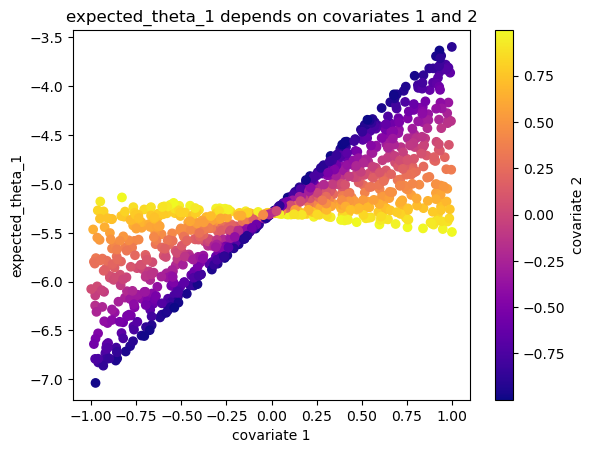

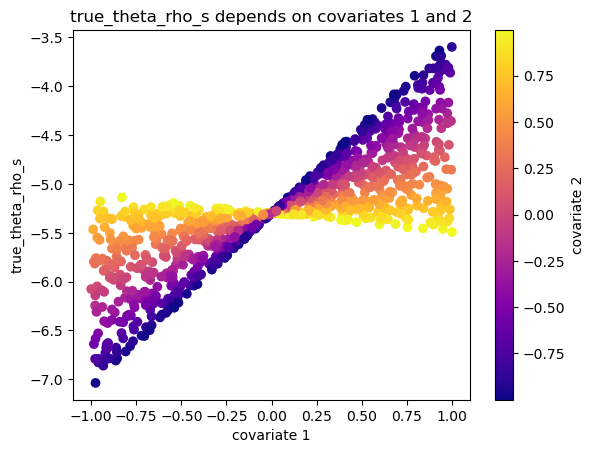

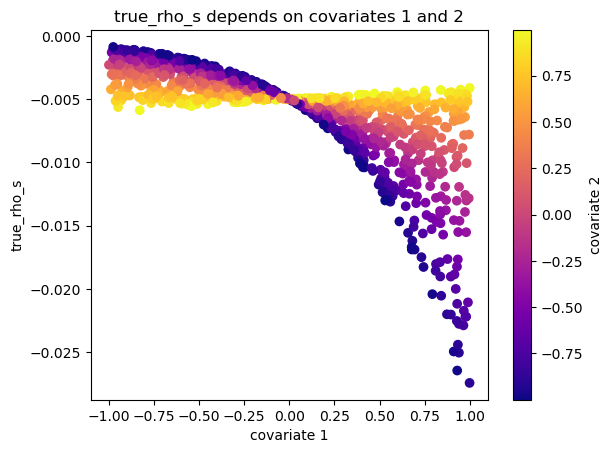

In [4]:
# Visualize parameter dependancy on covariates 
VISZ = True
if VISZ:
    color_array = X["Covariate 2"].to_numpy()

    fig, ax = plt.subplots()
    ax.set_title("expected_theta_1 depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], expected_theta_1, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("expected_theta_1")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

    fig, ax = plt.subplots()
    ax.set_title("true_theta_rho_s depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], true_theta_rho_s, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("true_theta_rho_s")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

    fig, ax = plt.subplots()
    ax.set_title("true_rho_s depends on covariates 1 and 2")
    points = ax.scatter(X["Covariate 1"], true_rho_s, c=color_array, cmap="plasma")
    ax.set_xlabel("covariate 1")
    ax.set_ylabel("true_rho_s")
    cbar = fig.colorbar(points)
    cbar.set_label('covariate 2', rotation=90)
    plt.show()

In [5]:
## Transpose and check that dimensions are correct
#Y = np.transpose(np.array([patient.Mprotein_values for _, patient in patient_dictionary.items()]))
#t = np.transpose(np.array([patient.measurement_times for _, patient in patient_dictionary.items()]))
#yi0 = np.array([patient.Mprotein_values[0] for _, patient in patient_dictionary.items()])
#yi0 = np.maximum(yi0, 1e-5)
##print("Y:\n", Y)
##print("t:\n", t)
##print("yi0:\n", yi0)
##print("X:\n", X)
#X_not_transformed = X.copy().T
#print(X_not_transformed.columns.values)
##X = X.T
#print("Shapes:")
#print("Y:", Y.shape)
#print("t:", t.shape)
#print("yi0:", yi0.shape)
#print("X:", X.shape)
#print("Done generating data")
#
#assert X.shape[0] == len(patient_dictionary)
#N_cases, P = X.shape
#print("N_cases:", N_cases)
#print(patient_dictionary[0].treatment_history[-1].end)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [6]:
## Check that histories stop at the last M protein measurement
#print(patient_dictionary[0].treatment_history[-1].end)
#print(patient_dictionary[0].measurement_times[-1])

1200.0
1200.0


Running simdata_BNN_M_5_P_3_N_cases_1000_psi_prior_yi0_N_samples_1000_N_tuning_1000_target_accept_0.99_max_treedepth_10_FUNNEL_REPARAMETRIZATION_False


/home/evenmm/anaconda3/envs/second_pymc_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/evenmm/anaconda3/envs/second_pymc_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Unknown prior option specified for psi; Using 'lognormal' prior


Sampling: [Y_obs, alpha, bias_in_pi_r, bias_in_rho_r, bias_in_rho_s, bias_out_pi_r, bias_out_rho_r, bias_out_rho_s, log_psi, omega, sigma_bias_in, sigma_bias_out, sigma_obs, sigma_weights, theta_pi_r, theta_rho_r, theta_rho_s, weights_in_pi_r, weights_in_rho_r, weights_in_rho_s, weights_out_pi_r, weights_out_rho_r, weights_out_rho_s, xi]
/home/evenmm/anaconda3/envs/second_pymc_env/lib/python3.8/site-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/evenmm/anaconda3/envs/second_pymc_env/lib/python3.8/site-packages/arviz/stats/density_utils.py:706: RuntimeWarning: overflow encountered in add
  grid = (grid_edges[1:] + grid_edges[:-1]) / 2
/home/evenmm/anaconda3/envs/second_pymc_env/lib/python3.8/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 10,698
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, alpha, sigma_weights, weights_in_rho_s, weights_in_rho_r, weights_in_pi_r, weights_out_rho_s, weights_out_rho_r, weights_out_pi_r, sigma_bias_in, bias_in_rho_s, bias_in_rho_r, bias_in_pi_r, sigma_bias_out, bias_out_rho_s, bias_out_rho_r, bias_out_pi_r, omega, theta_rho_s, theta_rho_r, theta_pi_r, xi, log_psi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11070 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9704, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Done sampling


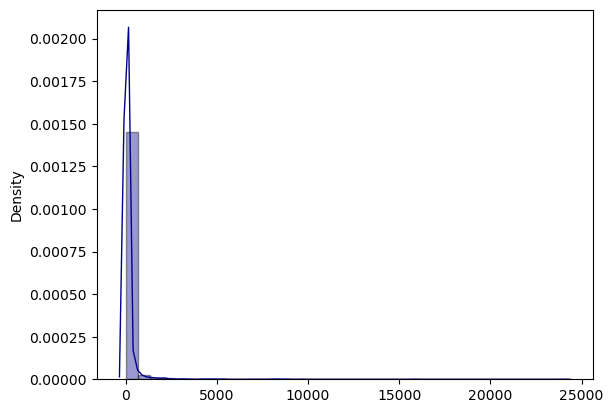

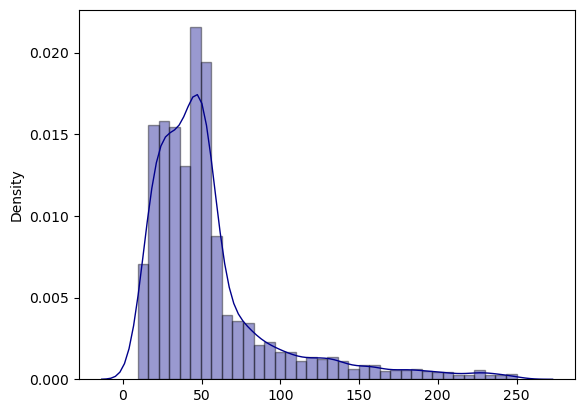

In [7]:
# Sample from full model
psi_prior="yi0" #"lognormal"
WEIGHT_PRIOR = "iso_normal" # "aki_vehtari_gaussian"
N_samples = 1000
N_tuning = 1000
N_advi = 500000
target_accept = 0.99
max_treedepth = 10
FUNNEL_REPARAMETRIZATION = False
name = "simdata_BNN_M_"+str(M_number_of_measurements)+"_P_"+str(P)+"_N_patients_"+str(N_patients)+"_psi_prior_"+psi_prior+"_N_samples_"+str(N_samples)+"_N_tuning_"+str(N_tuning)+"_target_accept_"+str(target_accept)+"_max_treedepth_"+str(max_treedepth)+"_FUNNEL_REPARAMETRIZATION_"+str(FUNNEL_REPARAMETRIZATION)
print("Running "+name)
neural_net_model = BNN_model(X, patient_dictionary, name, psi_prior=psi_prior, FUNNEL_REPARAMETRIZATION=FUNNEL_REPARAMETRIZATION, WEIGHT_PRIOR=WEIGHT_PRIOR)
# Draw samples from posterior:
with neural_net_model:
    # HMC 
    idata = pm.sample(draws=N_samples, tune=N_tuning, init="advi+adapt_diag", random_seed=42, target_accept=target_accept, max_treedepth=max_treedepth)
    # ADVI
    #inference = pm.ADVI() # diff="absolute")
    #approx = pm.fit(n=N_advi, method=inference)
    #trace = approx.sample(draws=N_samples)
    #idata = trace

# This is an xArray: https://docs.xarray.dev/en/v2022.11.0/user-guide/data-structures.html
print("Done sampling")

In [8]:
# Convergence checks
def quasi_geweke_test(idata, first=0.1, last=0.5, intervals=20):
    print("Running Geweke test...")
    convergence_flag = True
    for var_name in ['alpha', 'omega', 'theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r']:
        sample_shape = idata.posterior[var_name].shape
        n_chains = sample_shape[0]
        n_samples = sample_shape[1]
        var_dims = sample_shape[2]
        for chain in range(n_chains):
            for dim in range(var_dims):
                all_samples = np.ravel(idata.posterior[var_name][chain,:,dim])
                first_part = all_samples[0:int(n_samples*first)]
                last_part = all_samples[n_samples-int(n_samples*last):n_samples]
                z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
                if abs(z_score) >= 1.960:
                    convergence_flag = False
                    print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    for var_name in ['sigma_obs']:
        all_samples = np.ravel(idata.posterior[var_name])
        n_samples = len(all_samples)
        first_part = all_samples[0:int(n_samples*first)]
        last_part = all_samples[n_samples-int(n_samples*last):n_samples]
        z_score = (np.mean(first_part)-np.mean(last_part)) / np.sqrt(np.var(first_part)+np.var(last_part))
        if abs(z_score) >= 1.960:
            convergence_flag = False
            print("Seems like chain",chain,"has not converged in",var_name,"dimension",dim,": z_score is",z_score)
    if convergence_flag:
        print("All chains seem to have converged.")
    return 0

quasi_geweke_test(idata, first=0.1, last=0.5)

Running Geweke test...
Seems like chain 0 has not converged in alpha dimension 1 : z_score is -5.027024595727952
Seems like chain 1 has not converged in alpha dimension 2 : z_score is -2.6112420756592667
Seems like chain 2 has not converged in alpha dimension 0 : z_score is -2.3353901047844983
Seems like chain 3 has not converged in alpha dimension 2 : z_score is 2.9812618053545297
Seems like chain 0 has not converged in omega dimension 1 : z_score is -2.7342445957794705
Seems like chain 0 has not converged in omega dimension 2 : z_score is -2.5082128750969246
Seems like chain 1 has not converged in omega dimension 1 : z_score is -2.0909475630427776
Seems like chain 3 has not converged in omega dimension 0 : z_score is -2.1848047883484125
Seems like chain 0 has not converged in theta_rho_s dimension 254 : z_score is 2.468001995845564
Seems like chain 0 has not converged in theta_rho_s dimension 261 : z_score is -3.7102883883404956
Seems like chain 0 has not converged in theta_rho_s dim

0

array([<AxesSubplot: title={'center': 'sigma_obs\n0'}>,
       <AxesSubplot: title={'center': 'sigma_obs\n1'}>,
       <AxesSubplot: title={'center': 'sigma_obs\n2'}>,
       <AxesSubplot: title={'center': 'sigma_obs\n3'}>], dtype=object)

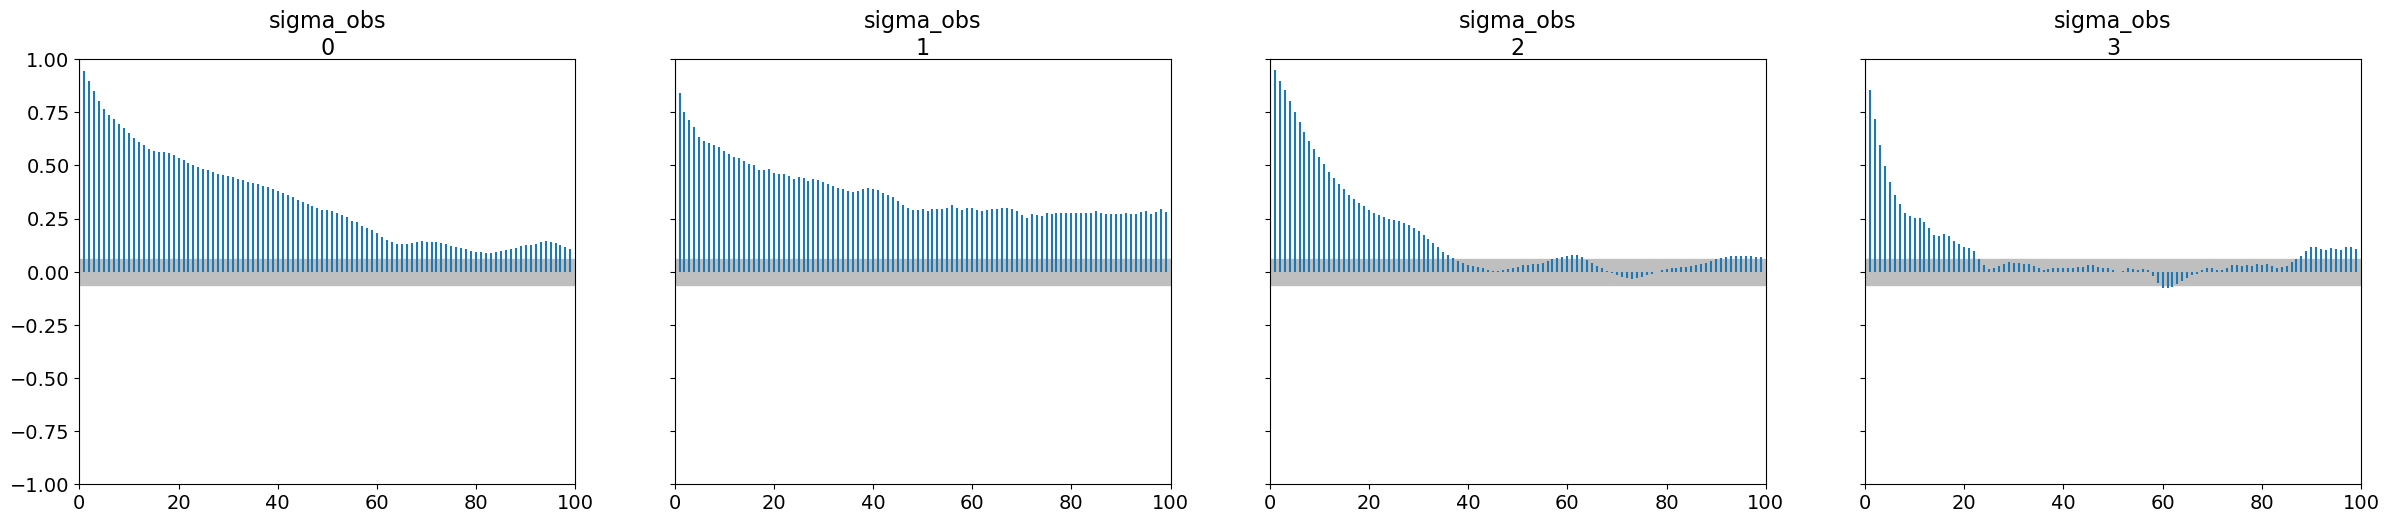

In [9]:
# Autocorrelation plots: 
az.plot_autocorr(idata, var_names=["sigma_obs"])
#az.plot_autocorr(idata, var_names=["alpha"]);
#az.plot_autocorr(idata, var_names=["omega"]);

In [10]:
# Posterior means 
#print('Posterior average of alpha:\n', np.mean(idata.posterior['alpha'], axis=(0,1)))
#print('\nPosterior average of omega:\n', np.mean(idata.posterior['omega'], axis=(0,1)))
#print('\nPosterior average of sigma_obs:\n', np.mean(idata.posterior['sigma_obs'], axis=(0,1)))

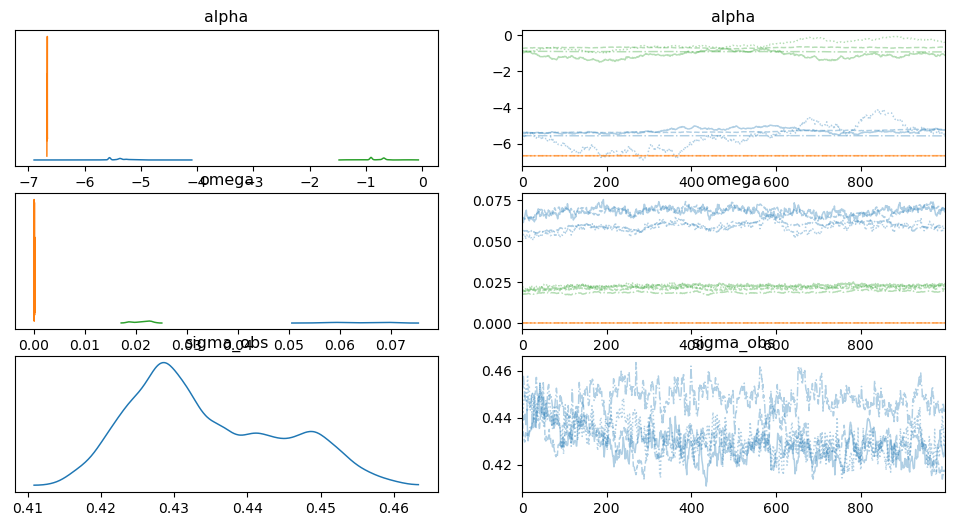

In [11]:
az.plot_trace(idata, var_names=('alpha', 'omega', 'sigma_obs'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters.png")

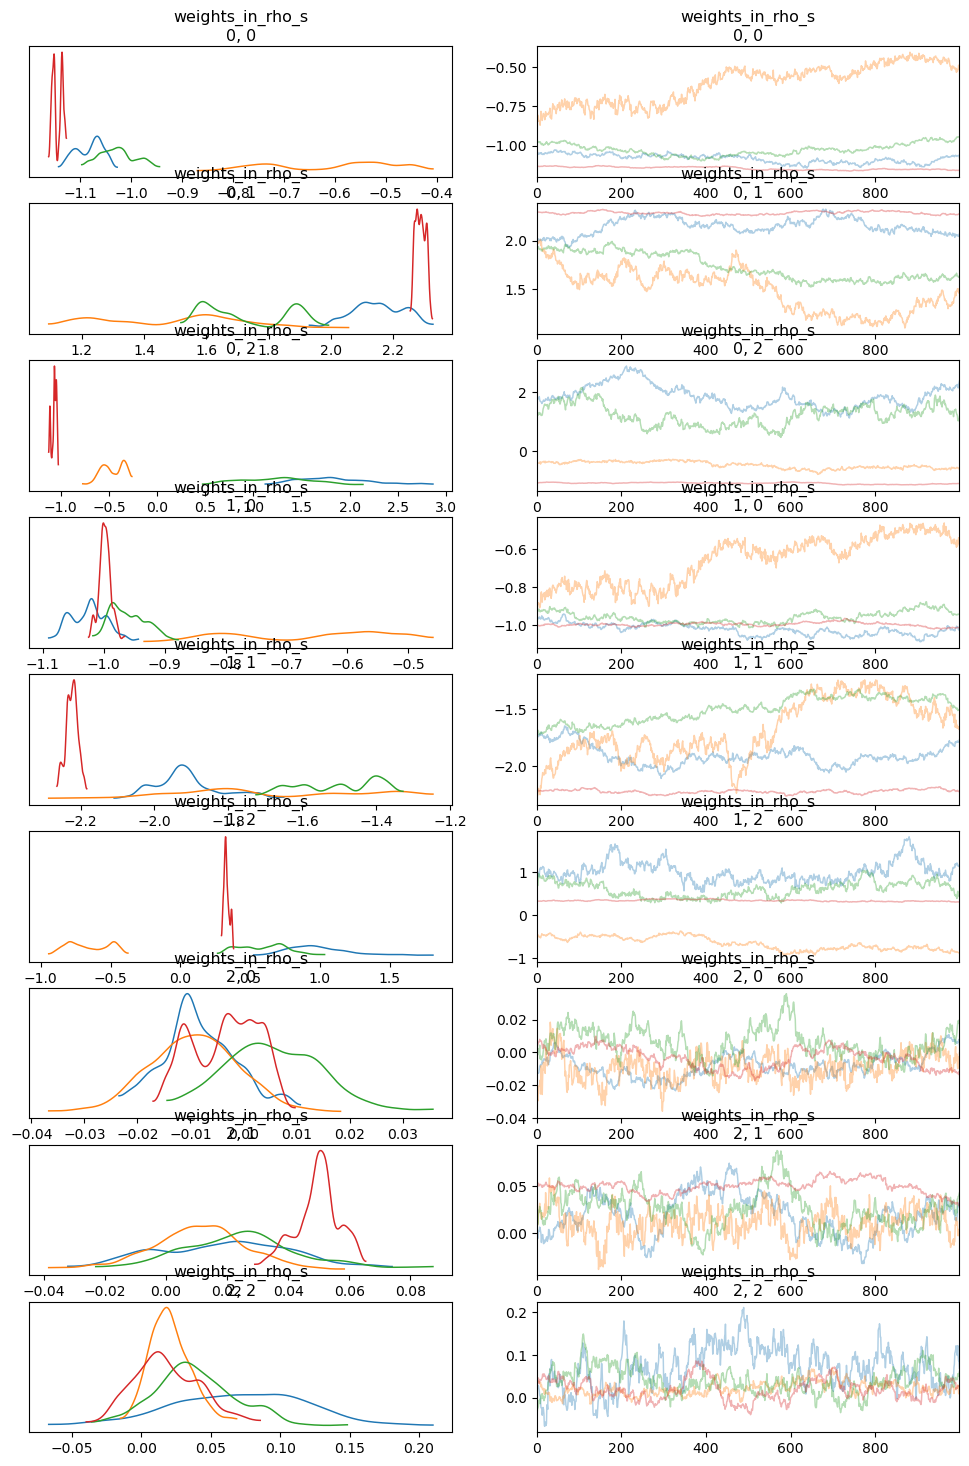

In [12]:
# Plot weights in_1 rho_s
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_in_rho_s'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_in_1_rho_s.png")

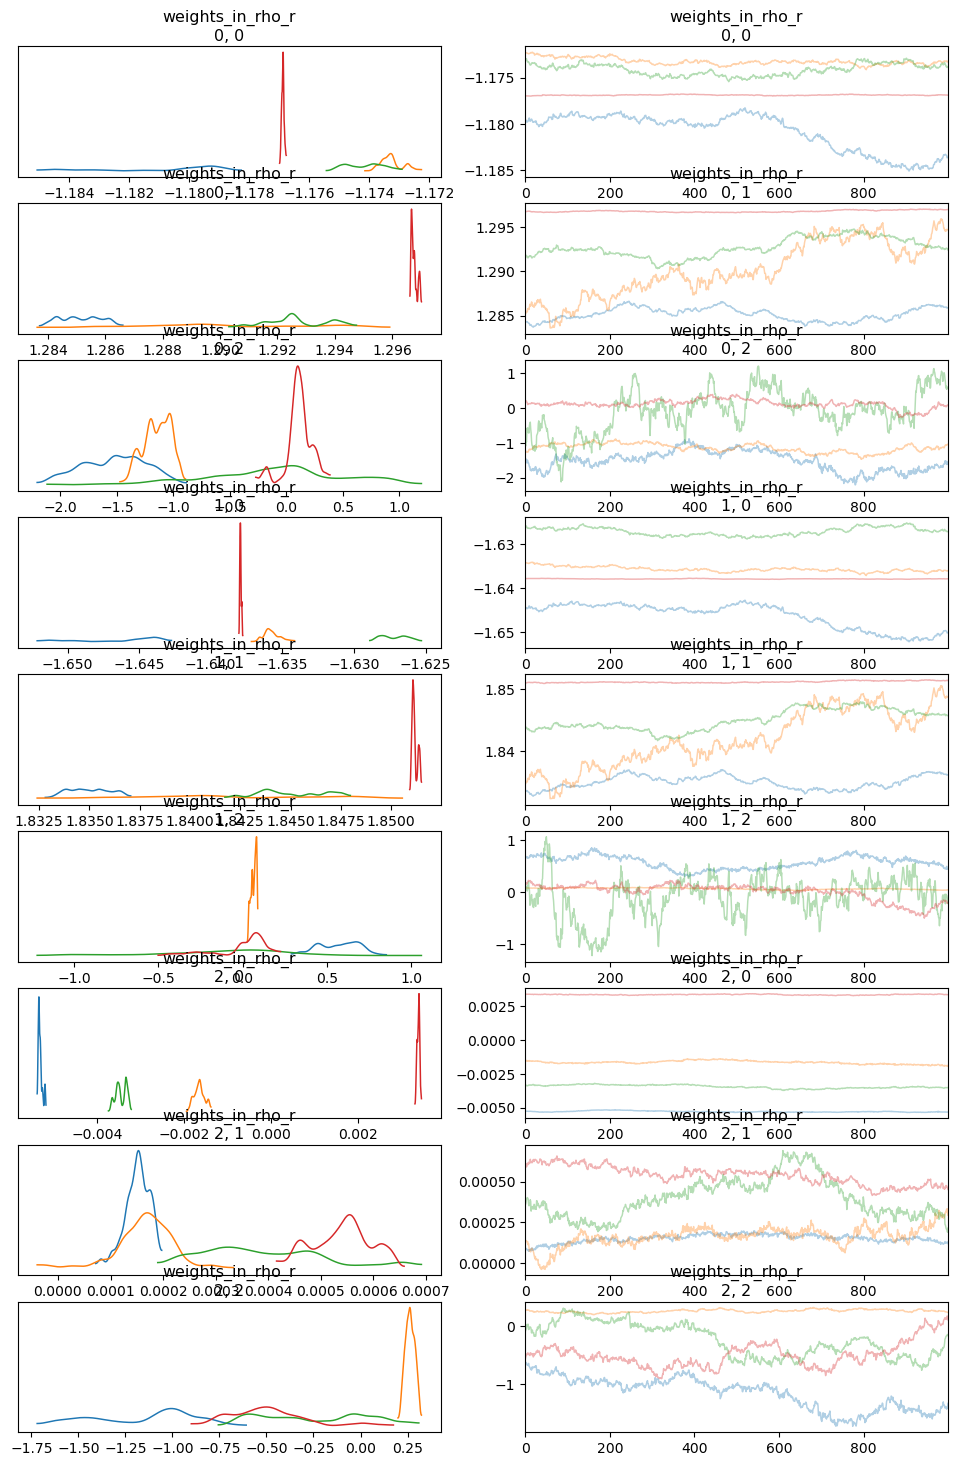

In [13]:
# Plot weights in_1 rho_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_in_rho_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_in_1_rho_r.png")

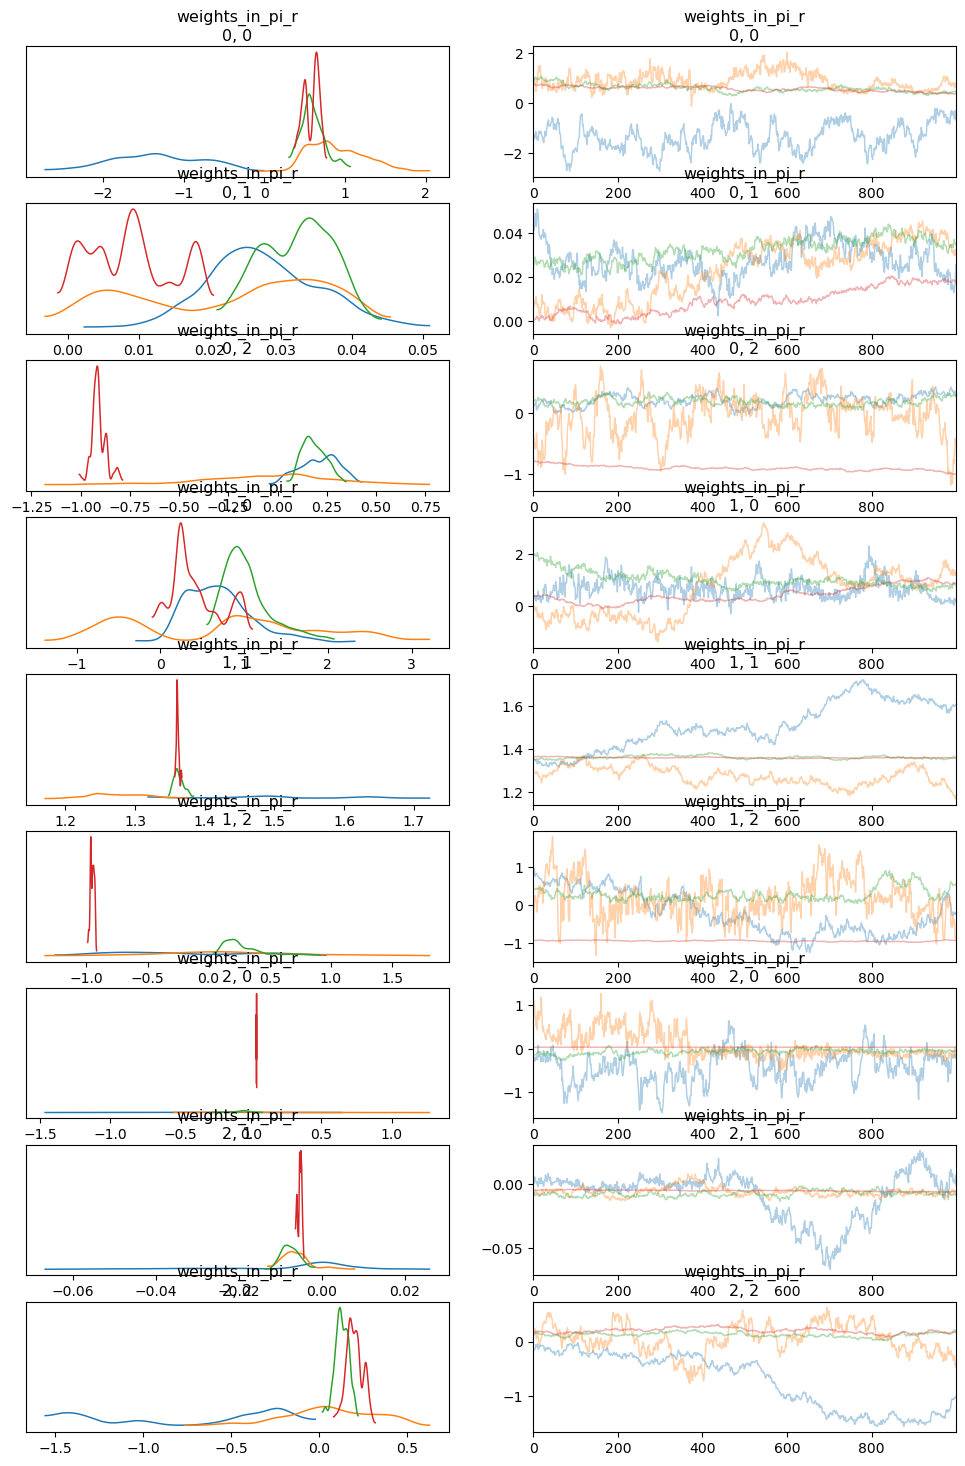

In [14]:
# Plot weights in_1 pi_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_in_pi_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_in_1_pi_r.png")

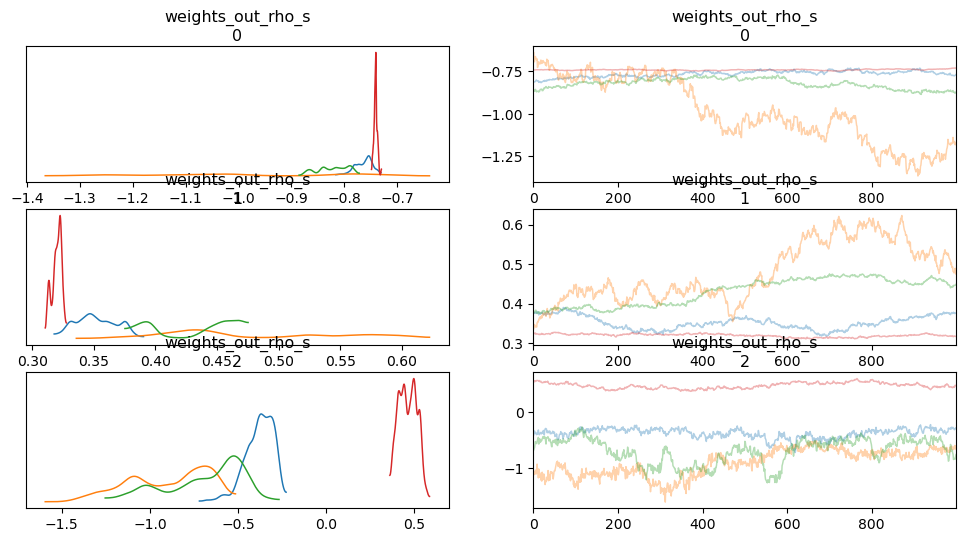

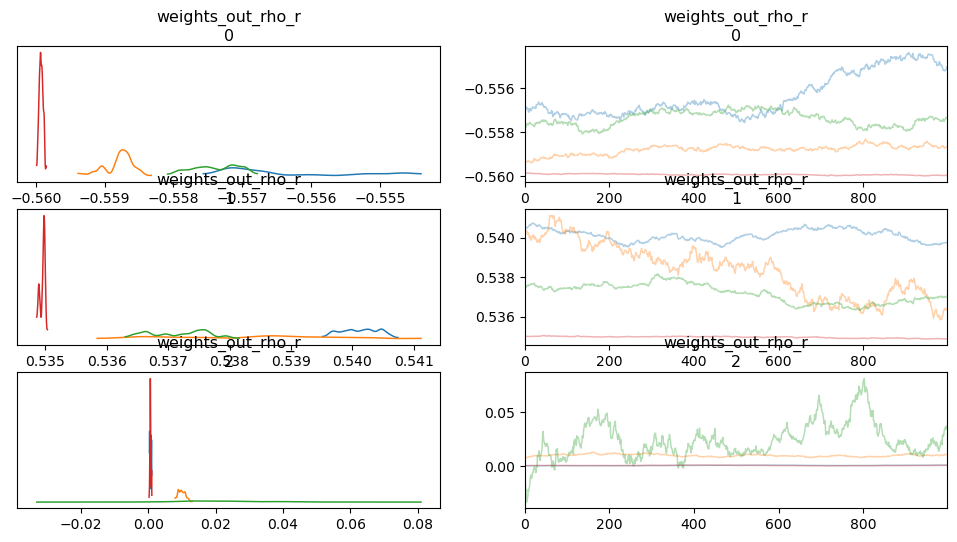

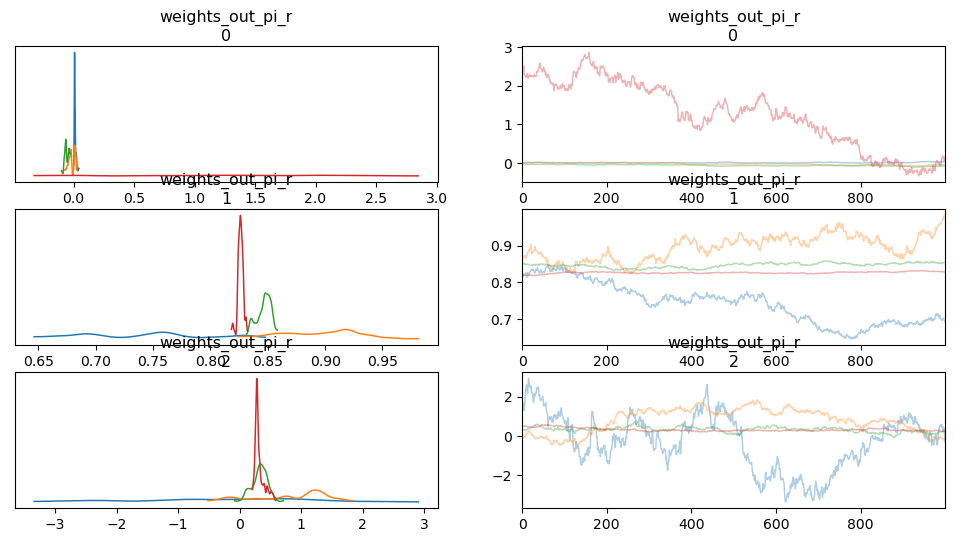

In [15]:
# Plot weights 2_out rho_s
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_out_rho_s'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_out_rho_s.png")
# There is also an effect where there are less resistant cells for the older patients.

# Plot weights 2_out rho_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_out_rho_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_out_rho_r.png")
# There is also an effect where there are less resistant cells for the older patients.

# Plot weights 2_out pi_r
# Combined means combine the chains into one posterior. Compact means split into different subplots
az.plot_trace(idata, var_names=('weights_out_pi_r'), combined=False, compact=False)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_uncompact_weights_out_pi_r.png")
# There is also an effect where there are less resistant cells for the older patients.


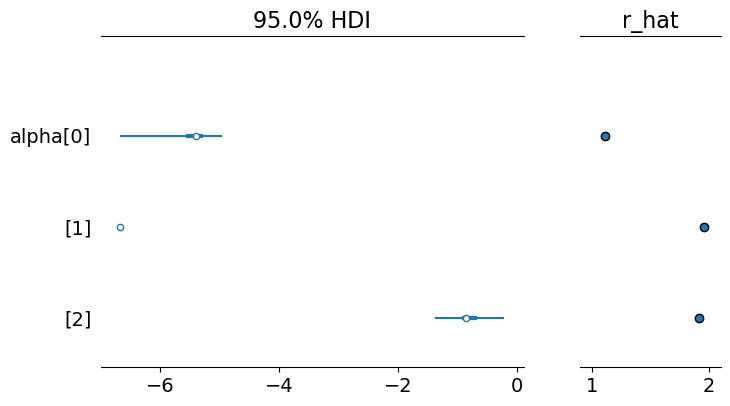

In [16]:
if psi_prior=="lognormal":
    az.plot_trace(idata, var_names=('xi'), combined=True)
    plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_group_parameters_xi.png")
    plt.close()
az.plot_trace(idata, var_names=('theta_rho_s', 'theta_rho_r', 'theta_pi_r', 'rho_s', 'rho_r', 'pi_r'), combined=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_posterior_individual_parameters.png")
plt.close()
# Test of exploration 
#az.plot_energy(idata)
#plt.savefig("./plots/posterior_plots/"+name+"-plot_energy.png")
#plt.close()
# Plot of coefficients
az.plot_forest(idata, var_names=["alpha"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_alpha.png")
az.plot_forest(idata, var_names=["theta_rho_s"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_s.png")
plt.close()
az.plot_forest(idata, var_names=["theta_rho_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_rho_r.png")
plt.close()
az.plot_forest(idata, var_names=["theta_pi_r"], combined=True, hdi_prob=0.95, r_hat=True)
plt.savefig("./plots/posterior_plots/"+name+"-plot_forest_theta_pi_r.png")
plt.close()

In [17]:
sample_shape = idata.posterior['psi'].shape # [chain, n_samples, dim]
n_chains = sample_shape[0]
n_samples = sample_shape[1]
var_dimensions = sample_shape[2] # one per patient
y_resolution = 20 # 1000 crashed the program

In [18]:
import multiprocessing
# Posterior CI for train data
def plot_posterior_CI(args):
    sample_shape, y_resolution, ii = args
    n_chains = sample_shape[0]
    n_samples = sample_shape[1]
    var_dimensions = sample_shape[2] # one per patient    

    patient = patient_dictionary[ii]
    measurement_times = patient.get_measurement_times() 
    treatment_history = patient.get_treatment_history()
    first_time = min(measurement_times[0], treatment_history[0].start)
    plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
    posterior_parameters = np.empty(shape=(n_chains, n_samples), dtype=object)
    predicted_y_values = np.empty(shape=(n_chains, n_samples, y_resolution))
    predicted_y_resistant_values = np.empty_like(predicted_y_values)
    for ch in range(n_chains):
        for sa in range(n_samples):
            this_sigma_obs = np.ravel(idata.posterior['sigma_obs'][ch,sa])
            this_psi       = np.ravel(idata.posterior['psi'][ch,sa,ii])
            this_pi_r      = np.ravel(idata.posterior['pi_r'][ch,sa,ii])
            this_rho_s     = np.ravel(idata.posterior['rho_s'][ch,sa,ii])
            this_rho_r     = np.ravel(idata.posterior['rho_r'][ch,sa,ii])
            posterior_parameters[ch,sa] = Parameters(Y_0=this_psi, pi_r=this_pi_r, g_r=this_rho_r, g_s=this_rho_s, k_1=0, sigma=this_sigma_obs)
            these_parameters = posterior_parameters[ch,sa]
            resistant_parameters = Parameters((these_parameters.Y_0*these_parameters.pi_r), 1, these_parameters.g_r, these_parameters.g_s, these_parameters.k_1, these_parameters.sigma)
            # Predicted total M protein
            predicted_y_values[ch,sa] = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)
            # Predicted resistant part
            predicted_y_resistant_values[ch,sa] = measure_Mprotein_noiseless(resistant_parameters, plotting_times, treatment_history)
    flat_pred_y_values = np.reshape(predicted_y_values, (n_chains*n_samples,y_resolution))
    sorted_local_pred_y_values = np.sort(flat_pred_y_values, axis=0)
    savename = "./plots/Bayesian_estimates_simdata_BNN/CI_training_id_"+str(ii)+name+".png"
    plot_posterior_local_confidence_intervals(ii, patient, sorted_local_pred_y_values, parameter_estimates=[], PLOT_POINT_ESTIMATES=False, PLOT_TREATMENTS=False, plot_title="Posterior CI for training patient "+str(ii), savename=savename, y_resolution=y_resolution, n_chains=n_chains, n_samples=n_samples)
    return 0 # {"posterior_parameters" : posterior_parameters, "predicted_y_values" : predicted_y_values, "predicted_y_resistant_values" : predicted_y_resistant_values}

y_resolution = 20 # 1000 crashed the program
args = [(sample_shape, y_resolution, ii) for ii in range(10)] # range(N_patients)
with Pool(15) as pool:
    results = pool.map(plot_posterior_CI,args)
# Gather all the parameter estimates and get y values for each parameter set
#posterior_parameters = [elem["posterior_parameters"] for elem in results]
#predicted_y_values = [elem["predicted_y_values"] for elem in results]
#predicted_y_resistant_values = [elem["predicted_y_resistant_values"] for elem in results]

In [30]:
# Generate test patients
N_patients_test = 30
test_seed = 23
RANDOM_EFFECTS_TEST=False
X_test, patient_dictionary_test, expected_theta_1_test, true_theta_rho_s_test, true_rho_s_test = generate_simulated_patients(M_number_of_measurements, days_between_measurements, measurement_times, treatment_history, true_sigma_obs, N_patients_test, P, get_expected_theta_from_X_one_interaction, true_omega, true_omega_for_psi, seed=test_seed, RANDOM_EFFECTS=RANDOM_EFFECTS_TEST)
print("Done generating test patients")

Done generating test patients


In [42]:
# Posterior predictive CI for test data
def plot_predictions(args):
    sample_shape, y_resolution, ii = args
    n_chains = sample_shape[0]
    n_samples = sample_shape[1]
    var_dimensions = sample_shape[2] # one per patient    

    patient = patient_dictionary_test[ii]
    measurement_times = patient.get_measurement_times() 
    treatment_history = patient.get_treatment_history()
    first_time = min(measurement_times[0], treatment_history[0].start)
    plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
    predicted_parameters = np.empty(shape=(n_chains, n_samples), dtype=object)
    predicted_y_values = np.empty(shape=(n_chains, n_samples, y_resolution))
    predicted_y_resistant_values = np.empty_like(predicted_y_values)
    for ch in range(n_chains):
        for sa in range(n_samples):
            sigma_obs = np.ravel(idata.posterior['sigma_obs'][ch,sa])
            alpha = np.ravel(idata.posterior['alpha'][ch,sa])
            sigma_weights = np.ravel(idata.posterior['sigma_weights'][ch,sa])
            # weights 
            #if FUNNEL_WEIGHTS == True: #...
                #weights_in_rho_s_offset
                #weights_in_rho_r_offset
                #weights_in_pi_r_offset
                #weights_in_rho_s
                #weights_in_rho_r
                #weights_in_pi_r
                #weights_out_rho_s_offset
                #weights_out_rho_r_offset
                #weights_out_pi_r_offset
                #weights_out_rho_s
                #weights_out_rho_r
                #weights_out_pi_r
            #else: ...
            weights_in_rho_s = idata.posterior['weights_in_rho_s'][ch,sa]
            weights_in_rho_r = idata.posterior['weights_in_rho_r'][ch,sa]
            weights_in_pi_r = idata.posterior['weights_in_pi_r'][ch,sa]
            weights_out_rho_s = idata.posterior['weights_out_rho_s'][ch,sa]
            weights_out_rho_r = idata.posterior['weights_out_rho_r'][ch,sa]
            weights_out_pi_r = idata.posterior['weights_out_pi_r'][ch,sa]

            # intercepts
            sigma_bias_in = np.ravel(idata.posterior['sigma_bias_in'][ch,sa])
            bias_in_rho_s = idata.posterior['bias_in_rho_s'][ch,sa]
            bias_in_rho_r = idata.posterior['bias_in_rho_r'][ch,sa]
            bias_in_pi_r = idata.posterior['bias_in_pi_r'][ch,sa]
            # Should include this
            sigma_bias_out = np.ravel(idata.posterior['sigma_bias_out'][ch,sa])
            bias_out_rho_s = np.ravel(idata.posterior['bias_out_rho_s'][ch,sa])
            bias_out_rho_r = np.ravel(idata.posterior['bias_out_rho_r'][ch,sa])
            bias_out_pi_r  = np.ravel(idata.posterior['bias_out_pi_r'][ch,sa])

            pre_act_1_rho_s = np.dot(X_test.iloc[ii,:], weights_in_rho_s) + bias_in_rho_s
            pre_act_1_rho_r = np.dot(X_test.iloc[ii,:], weights_in_rho_r) + bias_in_rho_r
            pre_act_1_pi_r  = np.dot(X_test.iloc[ii,:], weights_in_pi_r)  + bias_in_pi_r

            act_1_rho_s = np.select([pre_act_1_rho_s > 0, pre_act_1_rho_s <= 0], [pre_act_1_rho_s, pre_act_1_rho_s*0.01], 0)
            act_1_rho_r = np.select([pre_act_1_rho_r > 0, pre_act_1_rho_r <= 0], [pre_act_1_rho_r, pre_act_1_rho_r*0.01], 0)
            act_1_pi_r =  np.select([pre_act_1_pi_r  > 0, pre_act_1_pi_r  <= 0], [pre_act_1_pi_r,  pre_act_1_pi_r*0.01],  0)

            # Output activation function is just unit transform for prediction model
            act_out_rho_s = np.dot(act_1_rho_s, weights_out_rho_s) + bias_out_rho_s
            act_out_rho_r = np.dot(act_1_rho_r, weights_out_rho_r) + bias_out_rho_r
            act_out_pi_r =  np.dot(act_1_pi_r,  weights_out_pi_r)  + bias_out_pi_r

            predicted_theta_1 = alpha[0] + act_out_rho_s
            predicted_theta_2 = alpha[1] + act_out_rho_r
            predicted_theta_3 = alpha[2] + act_out_pi_r

            predicted_rho_s = - np.exp(predicted_theta_1)
            predicted_rho_r = np.exp(predicted_theta_2)
            predicted_pi_r  = 1/(1+np.exp(-predicted_theta_3))

            measurement_times = patient.get_measurement_times()
            treatment_history = patient.get_treatment_history()
            first_time = min(measurement_times[0], treatment_history[0].start)
            plotting_times = np.linspace(first_time, int(measurement_times[-1]), y_resolution) #int((measurement_times[-1]+1)*10))
            this_psi = patient.Mprotein_values[0]
            predicted_parameters[ch,sa] = Parameters(Y_0=this_psi, pi_r=predicted_pi_r, g_r=predicted_rho_r, g_s=predicted_rho_s, k_1=0, sigma=sigma_obs)
            these_parameters = predicted_parameters[ch,sa]
            resistant_parameters = Parameters(Y_0=(these_parameters.Y_0*these_parameters.pi_r), pi_r=1, g_r=these_parameters.g_r, g_s=these_parameters.g_s, k_1=these_parameters.k_1, sigma=these_parameters.sigma)
            # Predicted total M protein
            predicted_y_values[ch,sa] = measure_Mprotein_noiseless(these_parameters, plotting_times, treatment_history)
            # Predicted resistant part
            predicted_y_resistant_values[ch,sa] = measure_Mprotein_noiseless(resistant_parameters, plotting_times, treatment_history)
    flat_pred_y_values = np.reshape(predicted_y_values, (n_chains*n_samples,y_resolution))
    sorted_local_pred_y_values = np.sort(flat_pred_y_values, axis=0)
    flat_pred_resistant = np.reshape(predicted_y_resistant_values, (n_chains*n_samples,y_resolution))
    sorted_pred_resistant = np.sort(flat_pred_resistant, axis=0)
    savename = "./plots/Bayesian_estimates_simdata_BNN/CI_new_test_id_"+str(ii)+name+".png"
    plot_posterior_local_confidence_intervals(ii, patient, sorted_local_pred_y_values, parameter_estimates=[], PLOT_POINT_ESTIMATES=False, PLOT_TREATMENTS=False, plot_title="Posterior predictive CI for test patient "+str(ii), savename=savename, y_resolution=y_resolution, n_chains=n_chains, n_samples=n_samples, sorted_resistant_mprotein=sorted_pred_resistant)
    return 0 # {"posterior_parameters" : posterior_parameters, "predicted_y_values" : predicted_y_values, "predicted_y_resistant_values" : predicted_y_resistant_values}

N_patients_test = 5
y_resolution = 20 # 1000 crashed the program
args = [(sample_shape, y_resolution, ii) for ii in range(N_patients_test)]
with Pool(15) as pool:
    results = pool.map(plot_predictions,args)
# Gather all the parameter estimates and get y values for each parameter set
#posterior_parameters_test = [elem["posterior_parameters"] for elem in results]
#predicted_y_values_test = [elem["predicted_y_values"] for elem in results]
#predicted_y_resistant_values_test = [elem["predicted_y_resistant_values"] for elem in results]

In [32]:
# Checking that the X matches the observations and the precictions 
expected_theta_1, expected_theta_2, expected_theta_3 = get_expected_theta_from_X_one_interaction(X)

true_theta_rho_s = expected_theta_1
true_theta_rho_r = expected_theta_2
true_theta_pi_r  = expected_theta_3

psi_population = 50
true_theta_psi = np.random.normal(np.log(psi_population), true_omega_for_psi, size=N_patients)
true_rho_s = - np.exp(true_theta_rho_s)
true_rho_r = np.exp(true_theta_rho_r)
true_pi_r  = 1/(1+np.exp(-true_theta_pi_r))
true_psi = np.exp(true_theta_psi)

print(X_test.loc[0,:])

ttt = 4
for ttt in [13,14,15,16]:
    print("\n", )
    print(ttt)
    print(true_rho_s[ttt])
    print(true_rho_r[ttt])
    print(true_pi_r[ttt])


Covariate 1    0.034596
Covariate 2    0.893925
Covariate 3    0.530920
Name: 0, dtype: float64


13
[-0.00415039]
[0.00043184]
[0.22496193]


14
[-0.00508755]
[0.0011815]
[0.62129295]


15
[-0.00732929]
[0.00086153]
[0.30582719]


16
[-0.00571478]
[0.00056842]
[0.24996756]
